# 1. Imports

In [1]:
from art.attacks.evasion import *
from art.estimators.classification import TensorFlowV2Classifier

import numpy as np
from math import pi
from random import random, randint

import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt

from tensorflow.keras.losses import MSE
from tensorflow.keras.losses import categorical_crossentropy as CCE
from tensorflow.keras.models import load_model

import os
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [34]:
input_names = ['rho','theta','psi','v_own','v_int']

X_mean = np.array( [1.9791091*1e4, 0.0, 0.0, 650.0, 600.0] )
X_range = np.array( [60261.0, 6.28318530718, 6.28318530718, 1100.0, 1200.0] )
X_dom = np.array([ [0.0,    -pi, -pi, 100.0,     0.0],
                   [60760.0, pi,  pi, 1200.0, 1200.0] ])

# print(X_mean) ; print(X_range) ; print(X_dom) ; print("")

inputs_boundaries = np.zeros((2,5))
for k in range(5):
    inputs_boundaries[0,k] = (X_dom[0,k]-X_mean[k])/X_range[k]
    inputs_boundaries[1,k] = (X_dom[1,k]-X_mean[k])/X_range[k]

print("Frontieres du domaine :")
print(inputs_boundaries)

Frontieres du domaine :
[[-0.32842288 -0.5        -0.5        -0.5        -0.5       ]
 [ 0.67985777  0.5         0.5         0.5         0.5       ]]


# 2. Load models

In [3]:
path_model = "ACAS_XU_tf_keras/ACASXU_1_1.h5"

model_11 = load_model(path_model)

model_11.compile()

model_11.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_98 (Dense)             (None, 50)                300       
_________________________________________________________________
activation_98 (Activation)   (None, 50)                0         
_________________________________________________________________
dense_99 (Dense)             (None, 50)                2550      
_________________________________________________________________
activation_99 (Activation)   (None, 50)                0         
_________________________________________________________________
dense_100 (Dense)            (None, 50)                2550      
_________________________________________________________________
activation_100 (Activation)  (None, 50)                0         
_________________________________________________________________
dense_101 (Dense)            (None, 50)              

# 3. Home-made FGSM

In [ ]:
def generate_adv_sample(model, x0, label, loss_function="MSE", eps=1e-5):
    # transforming into a tensorflow object
    x0_ = tf.cast(x0, tf.float32)
    
    # record our gradients
    with tf.GradientTape() as tape:
        # explicitly indicate that our input should be tacked for gradient updates
        tape.watch(x0_)

        # use our model to make predictions on the input and then compute the loss
        pred = model(x0_)
        if loss_function == "CCE":
            np_label = np.array([i==label for i in range(0,5)]).reshape((1,5))
            loss = CCE(np_label, pred)
        elif loss_function == "MSE":
            loss = MSE(label, pred)
        else:
            raise Exception("Unknown loss function '{0}'".format(loss_function))
        
        # calculate the gradients of loss with respect to the input, then compute the sign of the gradient
        gradient = tape.gradient(loss, x0_)
        signedGrad = tf.sign(gradient)

        # construct the image adversary
        adv_sample = (x0_ + (signedGrad * eps)).numpy()

        # return the adversarial sample to the calling function
        return(adv_sample)

# 4. Generate points & check properties

In [ ]:
def random_pts(n, prop_dom, main_dom):
    """ prop_dom is a list of domains given by intervals in a numpy 2x5 table. """
    ndom = len(prop_dom)
    ndim = main_dom.shape[1]
    
    x = np.zeros((n,ndim))
    for i in range(n): # generate the i-th point
        choosen_dom = prop_dom[randint(0,ndom-1)] # choose the input property domain for a given prop
        for k in range(ndim): # create a random coord for each dim
            boundaries = main_dom[:,k]
            if choosen_dom[0,k] != None:
                boundaries[0] = choosen_dom[0,k]
            if choosen_dom[1,k] != None:
                boundaries[1] = choosen_dom[1,k]
            x[i,k] = boundaries[0] + random()*(boundaries[1]-boundaries[0])

    return(x)

In [ ]:
def random_main_pts(n, main_dom):
    """ Generate random points in the main domain given by intervals stored in a numpy 2x5 table. """
    ndim = main_dom.shape[1]
    
    x = np.zeros((n,ndim))
    for k in range(ndim): # create a random coord for each dim
        col = main_dom[0,k]*np.ones((n,1)) + np.random.rand(n,1)*(main_dom[1,k] - main_dom[0,k])
        for i in range(n):
            x[i,k] = col[i]

    return(x)

In [ ]:
x_test = random_main_pts(1000, X_dom)

In [ ]:
def normalize(x, x_mean, x_range):
    (n,k) = x.shape
    nx = np.zeros((n,k))
    for i in range(n):
        for j in range(k):
            nx[i,j] = (x[i,j]-x_mean[j])/x_range[j]
    return(nx)

In [ ]:
def check_pts(model, input_pts, IP, OP):
    n = input_pts.shape[0]
    IO_check = np.zeros((n,2)) # 1st column : input checked - 2nd column : output checked
    
    norm_input = normalize(input_pts, X_mean, X_range) # normalize pts
    
    pred_pts = model.predict(norm_input) # make predictions with the model (neural net)
    
    for k in range(n):
        IO_check[k,0] = IP(input_pts[k,:]) # check input (just in case)
        IO_check[k,1] = OP(pred_pts[k,:]) # check output

    return(IO_check, pred_pts)

In [ ]:
rand_inputs = random_pts(1000000, IP2_dom, X_dom)

In [ ]:
Pcheck, pred_pts = check_pts(model_11, rand_inputs, IP1, OP1)

In [ ]:
def find_adverse(input_pts, prop_check):
    n = prop_check.shape[0]
    index = []
    for k in range(n):
        if prop_check[k,0] and not(prop_check[k,1]):
            index.append(k)
    return(input_pts[index,:])

In [ ]:
adv = find_adverse(rand_inputs, Pcheck)
print(adv.shape)

In [ ]:
Pcheck.shape

# 5. Attack the networks : FGSM & CW

In [34]:
ACAS_model = load_model("ACAS_XU_tf_keras/ACASXU_2_4.h5")

> See ConfusionMatrix_PIERRE.ipynb for the attacks + confusion matrix

### Save points in a file .npy

In [30]:
np.save("clear_pts.npy",original_pts)

In [31]:
test_data = np.load("clear_pts.npy")

# 6. Test des categories manquantes

In [30]:
def full_nets_id():
    """ Get the id of the 45 neural networks. """
    nets_id = []
    for k in range(11,60):
        if k%10 != 0:
            nets_id.append( (str(k//10),str(k%10)) )
    return(nets_id)

In [31]:
# inputs_boundaries = np.array([[-0.32842288, -0.5, -0.5, -0.5, -0.5],
#                               [ 0.67985777,  0.5,  0.5,  0.5,  0.5]])

def create_random_pts(npts, bounds=inputs_boundaries):
    """ Generate npts random points in the domain defined by bound. """
    pts = np.random.rand(npts, 5)
    for f in range(0,5):
        pts[:,f] *= (bounds[1][f] - bounds[0][f])
        pts[:,f] += bounds[0][f]
    return(pts)

In [32]:
a = create_random_pts(10)
print(a)

[[ 0.1677703   0.38898248  0.347677   -0.05784558  0.47246717]
 [ 0.56561774  0.31474007 -0.33928224  0.33233638  0.43137226]
 [ 0.45666537  0.3828354  -0.00689867  0.1575067  -0.25423743]
 [ 0.62401965  0.30592069  0.41840733 -0.25193172  0.1853918 ]
 [-0.06442642  0.11038703  0.18289914 -0.28815126 -0.44960104]
 [ 0.67173732 -0.11216828 -0.22675566  0.26718589 -0.09807554]
 [ 0.49363988  0.03790187  0.0178762  -0.14660554  0.33888782]
 [ 0.65670354 -0.38612265 -0.2994481  -0.40140013 -0.22211865]
 [ 0.12048588  0.49360643 -0.37303431  0.39505076  0.02649933]
 [-0.22205889 -0.24889337 -0.11289956 -0.04367295 -0.14323859]]


In [35]:
def get_label_frequency(npts, nets_id=None, show=False):
    """ Create 'npts' random points in the domain and make a prediction on each one of them
        with every nnet whose id is in 'nets_id'. """
    
    if nets_id == None: # all 45 networks
        nets_id = full_nets_id()
    else:
        for k in range(0,len(nets_id)):
            (na,nb) = nets_id[k]
            nets_id[k] = (str(na),str(nb))
    nnets = len(nets_id)
    
    base_pts = create_random_pts(npts)
    all_freq = np.zeros((nnets,5))
    
    for k in range(0,nnets):
        
        # load the corresponding model
        (a,b) = nets_id[k]
        ACAS_model = load_model("ACAS_XU_tf_keras/ACASXU_{0}_{1}.h5".format(a,b), compile=False) # run-mode model only
        
        # make predictions and compute label frequencies
        base_pred = ACAS_model.predict(base_pts)                                                                              
        all_freq[k,:] = np.bincount(np.concatenate((np.argmin(base_pred, axis=1),np.arange(0,5)))) - np.ones(5)
        
        if show:
            print('ACAS-XU {0}-{1} : {2}'.format(a,b,all_freq[k,:]))
        
    return(all_freq.astype(int))

In [39]:
freq = get_label_frequency(1000000, show=True)

ACAS-XU 1-1 : [854791.  29945.  35506.  42838.  36920.]
ACAS-XU 1-2 : [848805.  44665.  34841.  34294.  37395.]
ACAS-XU 1-3 : [846771.  22278.  57592.  42255.  31104.]
ACAS-XU 1-4 : [845164.  58537.  23231.  35064.  38004.]
ACAS-XU 1-5 : [854152.  36155.  38355.  37949.  33389.]
ACAS-XU 1-6 : [855054.  58501.  72444.   7586.   6415.]
ACAS-XU 1-7 : [9.71651e+05 1.43670e+04 1.36020e+04 1.58000e+02 2.22000e+02]
ACAS-XU 1-8 : [9.95633e+05 1.98200e+03 2.37500e+03 1.00000e+00 9.00000e+00]
ACAS-XU 1-9 : [9.99337e+05 3.04000e+02 3.59000e+02 0.00000e+00 0.00000e+00]
ACAS-XU 2-1 : [8.47417e+05 8.64930e+04 3.60000e+01 5.51510e+04 1.09030e+04]
ACAS-XU 2-2 : [8.58326e+05 7.59330e+04 2.20000e+01 5.45030e+04 1.12160e+04]
ACAS-XU 2-3 : [8.42803e+05 9.72590e+04 2.00000e+00 4.93930e+04 1.05430e+04]
ACAS-XU 2-4 : [8.44392e+05 9.39440e+04 6.10000e+01 5.55010e+04 6.10200e+03]
ACAS-XU 2-5 : [8.50023e+05 8.30250e+04 1.17000e+02 6.58070e+04 1.02800e+03]
ACAS-XU 2-6 : [8.63634e+05 1.35917e+05 2.20000e+01 3.460

In [40]:
print(freq)

[[854791  29945  35506  42838  36920]
 [848805  44665  34841  34294  37395]
 [846771  22278  57592  42255  31104]
 [845164  58537  23231  35064  38004]
 [854152  36155  38355  37949  33389]
 [855054  58501  72444   7586   6415]
 [971651  14367  13602    158    222]
 [995633   1982   2375      1      9]
 [999337    304    359      0      0]
 [847417  86493     36  55151  10903]
 [858326  75933     22  54503  11216]
 [842803  97259      2  49393  10543]
 [844392  93944     61  55501   6102]
 [850023  83025    117  65807   1028]
 [863634 135917     22    346     81]
 [872063 127905      5     27      0]
 [875671 124312      0     17      0]
 [888275 111711      0     14      0]
 [858984      4  75210  11072  54730]
 [872825      3  58063  11088  58021]
 [849879      4  88284  10154  51679]
 [845450    188  93847   6216  54299]
 [852915     42  88853   1350  56840]
 [827995      3 171610     34    358]
 [872907      2 127074      0     17]
 [881036      0 118912      0     52]
 [874701    

In [41]:
np.save("one_million_pts.npy",freq)

## Histplots and plots

In [42]:
ACAS_labels = ["COC","WR","WL","SR","SL"]

In [43]:
multiplot_pos = [(0,0),(0,1),(0,2),(1,1),(1,2)]
labels_color = [(0.5529411764705883, 0.6274509803921569, 0.796078431372549),
                (0.4, 0.7607843137254902, 0.6470588235294118),
                (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
                (0.8980392156862745, 0.7686274509803922, 0.5803921568627451),
                (0.9882352941176471, 0.5529411764705883, 0.3843137254901961)]
sns.color_palette("Set2")

[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
 (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
 (1.0, 0.8509803921568627, 0.1843137254901961),
 (0.8980392156862745, 0.7686274509803922, 0.5803921568627451),
 (0.7019607843137254, 0.7019607843137254, 0.7019607843137254)]

In [44]:
df_freq = pd.DataFrame(freq, columns = ACAS_labels)
df_freq.head()

,COC,WR,WL,SR,SL
0,854791,29945,35506,42838,36920
1,848805,44665,34841,34294,37395
2,846771,22278,57592,42255,31104
3,845164,58537,23231,35064,38004
4,854152,36155,38355,37949,33389


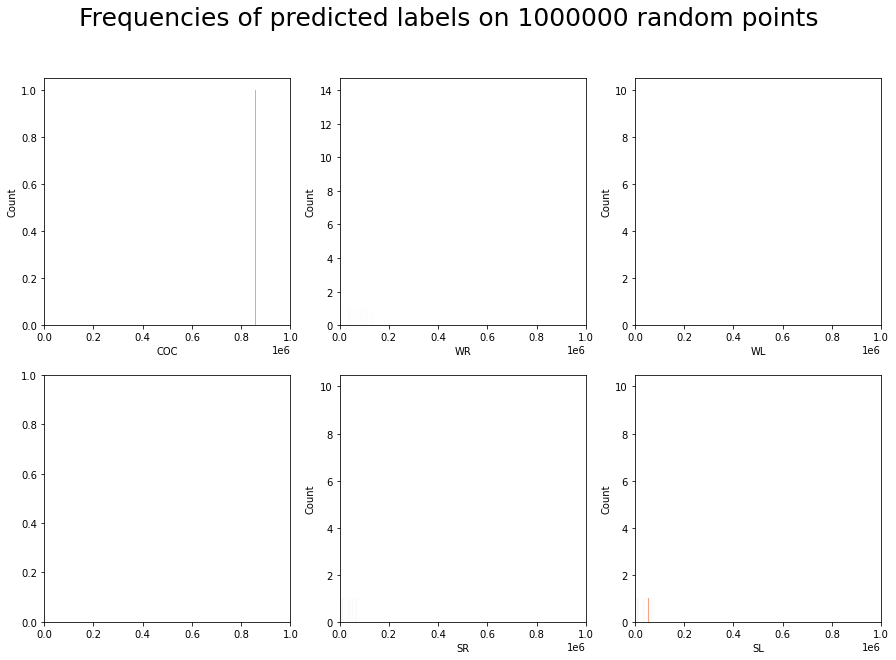

In [46]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10)) #, sharey=True)
fig.suptitle("Frequencies of predicted labels on {0} random points".format(np.sum(freq[0,:])), size=25)

bar_width = 25

for k in range(5):
    sns.histplot(ax=axes[multiplot_pos[k]], data = df_freq[ACAS_labels[k]], binwidth = bar_width, color = labels_color[k])
    axes[multiplot_pos[k]].set_xlim(0,1000000)

plt.show()

In [47]:
sorted_index = np.argsort(freq, axis=0)

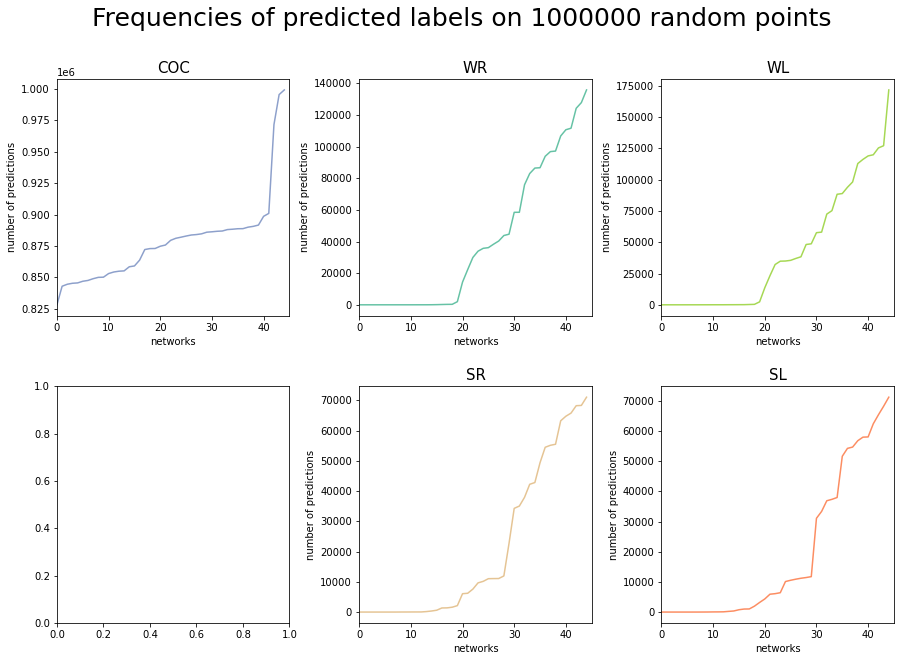

In [48]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10)) #, sharey=True)
plt.subplots_adjust(wspace = 0.3, hspace = 0.3)
fig.suptitle("Frequencies of predicted labels on {0} random points".format(np.sum(freq[0,:])), size=25)

for k in range(5):
    axes[multiplot_pos[k]].plot(freq[:,k][sorted_index[:,k]], color = labels_color[k])
    axes[multiplot_pos[k]].set_xlim(0,45)
    axes[multiplot_pos[k]].set_title(ACAS_labels[k], size=15)
    axes[multiplot_pos[k]].set_xlabel("networks") ; axes[multiplot_pos[k]].set_ylabel("number of predictions")
    
plt.show()

# Classes of networks

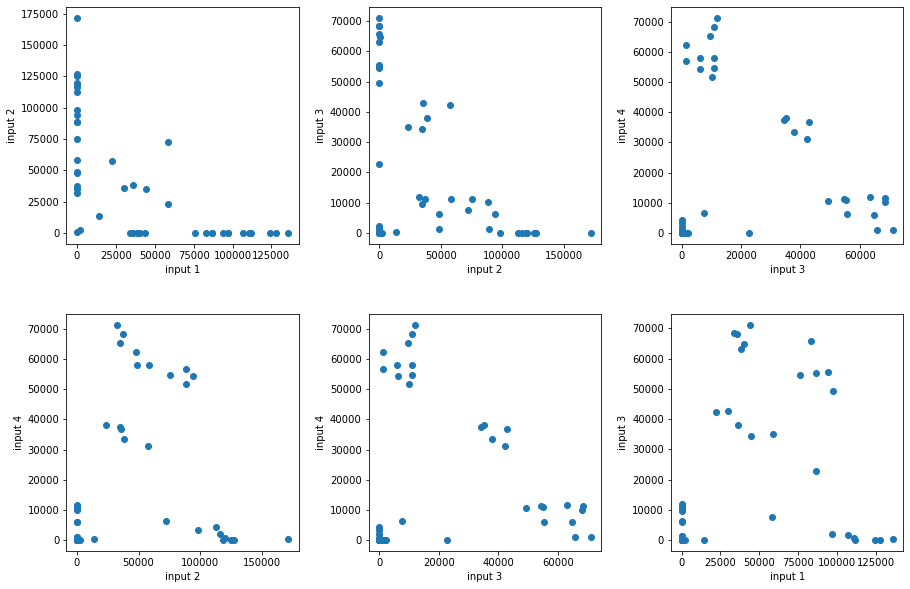

In [49]:
multiplot_pos = [(0,0),(0,1),(0,2),(1,0),(1,1),(1,2)]
choose_inputs = [(1,2),(2,3),(3,4),(2,4),(3,4),(1,3)]

fig, axes = plt.subplots(2, 3, figsize=(15, 10)) #, sharey=True)
plt.subplots_adjust(wspace = 0.3, hspace = 0.3)
# fig.suptitle("Frequencies of predicted labels on {0} random points".format(np.sum(freq[0,:])), size=25)

for k in range(6):
    axes[multiplot_pos[k]].scatter(freq[:,choose_inputs[k][0]],freq[:,choose_inputs[k][1]])
    axes[multiplot_pos[k]].set_xlabel("input {0}".format(choose_inputs[k][0]))
    axes[multiplot_pos[k]].set_ylabel("input {0}".format(choose_inputs[k][1]))
    
plt.show()

In [50]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score as sil_score

In [55]:
pca = PCA(n_components=4)
y = pca.fit_transform(freq[:,[1,2,3,4]])
var_ratio = pca.explained_variance_ratio_
print(var_ratio)

[0.68023374 0.18094136 0.08579388 0.05303102]


Text(0, 0.5, 'CP n°2 (18%)')

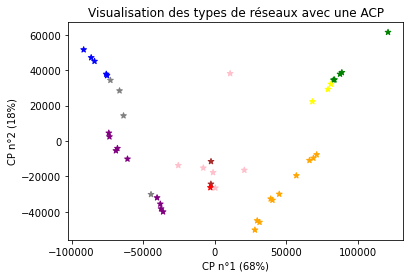

In [123]:
plt.scatter(y[:,0], y[:,1], color=to_colors(nets_type), marker="*")
plt.title("Visualisation des types de réseaux avec une ACP")
plt.xlabel("CP n°1 ({0}%)".format(int(100*var_ratio[0])))
plt.ylabel("CP n°2 ({0}%)".format(int(100*var_ratio[1])))

In [120]:
def get_network_type(line, threshold = 0.001):
    """ Codage en base 2 du type du réseau : bit de poids k = 1 si line[5-k]>borne et 0 sinon """
    borne = int(threshold*np.sum(line))
    num = 0
    for k in range(0,5):
        num *= 2
        if line[k]>borne:
            num += 1
    return(num)

In [100]:
u = np.array([125,179,658,36,2]) # sum = 1000
x = get_network_type(u, threshold=0.01)
print("type =",x)

type = 30


In [121]:
nets_type = np.array([get_network_type(line) for line in freq]) #; print(nets_type)
nets_bool = np.ones(45)

for k in range(32): # 32 types de clusters
    id_nets = np.where(nets_type == k)[0]
    if len(id_nets) > 0:
        print("Cluster {0}".format(k))
        for i in id_nets:
            print("#{0} : {1}".format(i,freq[i])) ; nets_bool[i] = 0
        print("")

print("Remaining pts :")
for i in range(45):
    if nets_bool[i]:
        print("NET {0} : {1}".format(i,freq[i]))
print("")

Cluster 16
#8 : [999337    304    359      0      0]

Cluster 20
#23 : [827995      3 171610     34    358]
#24 : [872907      2 127074      0     17]
#25 : [881036      0 118912      0     52]
#26 : [874701      0 125298      0      1]
#43 : [879395      0 119835      0    770]

Cluster 21
#41 : [898563    101  98115     32   3189]
#42 : [882829      6 112821      0   4344]
#44 : [881906      0 116135      0   1959]

Cluster 23
#18 : [858984      4  75210  11072  54730]
#19 : [872825      3  58063  11088  58021]
#20 : [849879      4  88284  10154  51679]
#21 : [845450    188  93847   6216  54299]
#22 : [852915     42  88853   1350  56840]
#36 : [883656     16  37014  11039  68275]
#37 : [884600      0  32176  11948  71276]
#38 : [889918     13  34969   9652  65448]
#39 : [886843    270  48725   6068  58094]
#40 : [887983     19  48163   1384  62451]

Cluster 24
#14 : [863634 135917     22    346     81]
#15 : [872063 127905      5     27      0]
#16 : [875671 124312      0     17     

In [122]:
colors = ['red','green','yellow','orange','blue','grey','purple','brown','pink']

unique_labels = np.unique(nets_type)
type2col = {}
for k in range(len(unique_labels)):
    type2col[unique_labels[k]] = colors[k]
cluster_colors = [ type2col[nets_type[k]] for k in range(len(nets_type)) ]

print(type2col)

{16: 'red', 20: 'green', 21: 'yellow', 23: 'orange', 24: 'blue', 26: 'grey', 27: 'purple', 28: 'brown', 31: 'pink'}


super clusters :
20 21 = green yellow
24 26 = blue grey
27 = purple
23 = orange
28 = brown
31 = pink (FULL NET)
16 = red (COC NET)

In [136]:
# Clusters identifies pour {npts = 1000000 ; threshold = 0.001}
c2021 = [23,24,25,26,43,41,42,44]
c2426 = [14,15,16,17,34,31,32,33,35]
c27 = [9,10,11,12,13,27,28,29,30]
c23 = [18,19,20,21,22,36,37,38,39,40]
c28 = [6,7]
c31 = [0,1,2,3,4,5]
c16 = [8]

nets_clusters = [c2021,c2426,c27,c23,c28,c31,c16]

print("### CLUSTERING DES RESEAUX :\n")
for nc in range(len(nets_clusters)):
    print("------------------------ CLUSTER {0} ------------------------".format(nc))
    string_clusters = [str(k) for k in nets_clusters[nc]]
    print("Réseaux : {0}".format(" - ".join(string_clusters)))
    print("Nb de réseaux = {0}".format(len(string_clusters)))
    print("")

### CLUSTERING DES RESEAUX :

------------------------ CLUSTER 0 ------------------------
Réseaux : 23 - 24 - 25 - 26 - 43 - 41 - 42 - 44
Nb de réseaux = 8

------------------------ CLUSTER 1 ------------------------
Réseaux : 14 - 15 - 16 - 17 - 34 - 31 - 32 - 33 - 35
Nb de réseaux = 9

------------------------ CLUSTER 2 ------------------------
Réseaux : 9 - 10 - 11 - 12 - 13 - 27 - 28 - 29 - 30
Nb de réseaux = 9

------------------------ CLUSTER 3 ------------------------
Réseaux : 18 - 19 - 20 - 21 - 22 - 36 - 37 - 38 - 39 - 40
Nb de réseaux = 10

------------------------ CLUSTER 4 ------------------------
Réseaux : 6 - 7
Nb de réseaux = 2

------------------------ CLUSTER 5 ------------------------
Réseaux : 0 - 1 - 2 - 3 - 4 - 5
Nb de réseaux = 6

------------------------ CLUSTER 6 ------------------------
Réseaux : 8
Nb de réseaux = 1



# Kmeans...

In [22]:
kmeans = KMeans(n_clusters=10)
kmeans.fit(freq)
print(kmeans.labels_)
print(np.bincount(kmeans.labels_))

[5 5 5 0 8 0 0 0 0 1 8 1 1 3 3 0 3 3 9 5 2 9 5 9 4 4 9 3 0 3 0 6 3 0 3 3 0
 2 7 0 5 0 0 5 5]
[13  3  2  9  2  8  1  1  2  4]


In [ ]:
for k in range(10):
    print("Cluster {0}".format(k))
    for i in range(45):
        if kmeans.labels_[i] == k:
            print(freq[i])
    print("")

In [49]:
ncluster = [k for k in range(4,45)]
sscore = np.zeros(len(ncluster))

for i in range(0,len(ncluster)):
    nc = ncluster[i]
    kmeans = KMeans(n_clusters=nc)
    kmeans.fit(freq)
    klabels = kmeans.labels_

    sscore[i] = sil_score(freq, labels = klabels)
    print("nc = {0} - sil_score = {1}".format(nc,sscore[i]))

nc = 4 - sil_score = 0.3365849144741345
nc = 5 - sil_score = 0.3508289814517803
nc = 6 - sil_score = 0.36515309638028476
nc = 7 - sil_score = 0.3690336522015351
nc = 8 - sil_score = 0.3154104233854524
nc = 9 - sil_score = 0.341840541852728
nc = 10 - sil_score = 0.34641803219759915
nc = 11 - sil_score = 0.3498657594886785
nc = 12 - sil_score = 0.35442180394987144
nc = 13 - sil_score = 0.3418730189226805
nc = 14 - sil_score = 0.3325547720025993
nc = 15 - sil_score = 0.32167049756840727
nc = 16 - sil_score = 0.3159172605727167
nc = 17 - sil_score = 0.3103652518021586
nc = 18 - sil_score = 0.32694025659785625
nc = 19 - sil_score = 0.32095177799520486
nc = 20 - sil_score = 0.29817458633686134
nc = 21 - sil_score = 0.30203987176784874
nc = 22 - sil_score = 0.276466498853856
nc = 23 - sil_score = 0.27293290721351865
nc = 24 - sil_score = 0.25991510596544337
nc = 25 - sil_score = 0.28134145559910695
nc = 26 - sil_score = 0.2685829043678244
nc = 27 - sil_score = 0.27700744368429525
nc = 28 - si

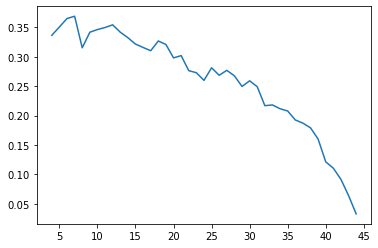

In [50]:
plt.plot(ncluster,sscore)

In [56]:
a = np.argsort(sscore)

In [57]:
for k in range(0,len(sscore)):
    print("nc = {0} - sil_score = {1}".format(ncluster[a[k]],sscore[a[k]]))

nc = 44 - sil_score = 0.03270507855345297
nc = 43 - sil_score = 0.06400027990948862
nc = 42 - sil_score = 0.09148037847877855
nc = 41 - sil_score = 0.11050212542449561
nc = 40 - sil_score = 0.12133943986175358
nc = 39 - sil_score = 0.16008083700759562
nc = 38 - sil_score = 0.1791545500813978
nc = 37 - sil_score = 0.18718632418201778
nc = 36 - sil_score = 0.19256160318270324
nc = 35 - sil_score = 0.20781260872469795
nc = 34 - sil_score = 0.2116708270535103
nc = 32 - sil_score = 0.21688896106885266
nc = 33 - sil_score = 0.21809978924409026
nc = 31 - sil_score = 0.24911201142605657
nc = 29 - sil_score = 0.24957307149263827
nc = 30 - sil_score = 0.25918647502927195
nc = 24 - sil_score = 0.25991510596544337
nc = 28 - sil_score = 0.26765871564823385
nc = 26 - sil_score = 0.2685829043678244
nc = 23 - sil_score = 0.27293290721351865
nc = 22 - sil_score = 0.276466498853856
nc = 27 - sil_score = 0.27700744368429525
nc = 25 - sil_score = 0.28134145559910695
nc = 20 - sil_score = 0.298174586336861

In [61]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(freq)
print(kmeans.labels_)
print(np.bincount(kmeans.labels_))

[0 0 0 0 0 0 0 0 0 1 3 1 1 3 3 3 3 3 0 0 2 0 0 0 2 2 2 3 0 3 0 1 3 3 3 3 0
 2 1 0 0 0 0 0 0]
[23  5  5 12]


In [62]:
for k in range(7):
    print("Cluster {0}".format(k))
    for i in range(45):
        if kmeans.labels_[i] == k:
            print(freq[i])
    print("")

Cluster 0
[9185    9  250  263  293]
[8977   96  425   54  448]
[9291    6  376  159  168]
[9372   59   34  268  267]
[8899    5   17  980   99]
[9641   38  176   91   54]
[9713    1    4    4  278]
[9730   58    2  210    0]
[10000     0     0     0     0]
[8687    0 1074   12  227]
[9145    0  394    9  452]
[8992    0  910   14   84]
[9065    0  744    6  185]
[8777    0 1218    0    5]
[9327  332    7  295   39]
[9251  210    0  450   89]
[9440    0  106   65  389]
[9487    0  241   34  238]
[8662   65  472   70  731]
[9457   37  414   12   80]
[9519   22  322    0  137]
[9096    0  696    0  208]
[9309    0  498    0  193]

Cluster 1
[6763 2483    0  753    1]
[7642 1357    0  987   14]
[7163 1328    0 1499   10]
[6184  479  380 2934   23]
[7524    0  258 1108 1110]

Cluster 2
[7887    0 1190    7  916]
[7610    0 2385    0    5]
[6907    0 3075    0   18]
[8241    0 1720   32    7]
[7918    0 1082   15  985]

Cluster 3
[8277  435    2 1192   94]
[9116  733    0  151    0]
[8884 1

In [71]:
def inside_cluster(pt, zeros_ind=[]):
    """ True if the only zeros of pt are those whose positions are written in zeros_ind. """
    for x in range(5):
        if (x in zeros_ind) and (pt[x] != 0):
            return(False)
        elif not(x in zeros_ind) and (pt[x] == 0):
            return(False)
    return(True)

In [72]:
poss_clusters = [[1,3], [1], [2], [2,4]]